In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os

Reading JLA covariance matrix and examinate the min, max and mean from it. 

In [2]:
syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))

-0.0166258178256 0.0347767817719 0.0025805871334024376


Heat map to cov matrix:

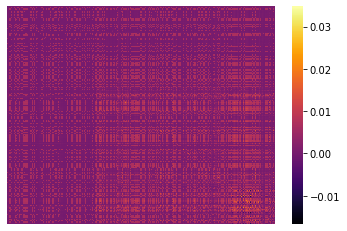

In [3]:
dfcov = pd.DataFrame(syscov)
sns.heatmap(dfcov, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')

Verify that the cov matrix is symmetrical:

In [4]:
count = 0
for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
            print(i,j)
            print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]
print(count)

0 10
9.33387814202e-05 9.33387814201e-05
0 75
9.05443602016e-05 9.05443602015e-05
2 68
5.84269431267e-05 5.84269431266e-05
3 107
0.000136763299594 0.000136763299593
3 175
6.821596824e-05 6.82159682399e-05
4 19
0.000218987354692 0.000218987354691
7 224
6.57226796625e-05 6.57226796624e-05
8 13
9.57880153294e-05 9.57880153295e-05
8 26
0.00661609551033 0.00661609551034
8 96
0.000253469634018 0.000253469634019
8 154
9.9063520192e-05 9.90635201921e-05
8 227
-3.79691626194e-06 -3.79691626193e-06
8 231
0.000255139378748 0.000255139378749
9 157
6.23071374699e-05 6.23071374698e-05
10 116
5.51821214604e-05 5.51821214603e-05
12 198
6.16747798165e-05 6.16747798164e-05
13 18
7.67427279413e-05 7.67427279412e-05
13 121
9.04513387774e-05 9.04513387773e-05
13 218
6.97373549281e-05 6.9737354928e-05
14 68
3.2722108844e-06 3.27221088441e-06
14 81
9.91102935493e-06 9.91102935494e-06
14 85
-1.71950071068e-07 -1.71950071066e-07
15 92
0.000216399317748 0.000216399317747
17 172
1.76995240946e-07 1.76995240947e-

Add the statistical error to the diag of the covariance matrix:

In [5]:
file = 'data/jla_lcparams.txt'

data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
X = data.values[:,0]
staterr = data.values[:,2]
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)
print(mincov, maxcov, meancov)

(740, 740) (740, 740)
-0.0166258178256 0.0633448802129 0.0025992186787941202


See the new covariance matrix:

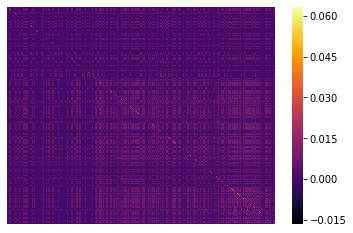

In [6]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno',
            vmax=maxcov, vmin=mincov)
# ,robust=True)

Extract eigenvalues and eigen vectors. Show the eigenvector matrix.

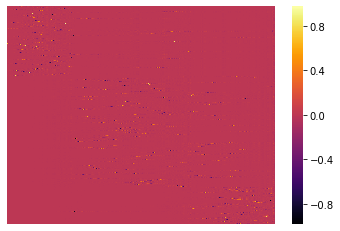

In [7]:
eigenval, eigenvec = sp.linalg.eigh(covfull)
df_eig = pd.DataFrame(eigenvec)
sns.heatmap(df_eig, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno')
#             robust=True)

Orthonormalization of the eigenvector matrix

In [8]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

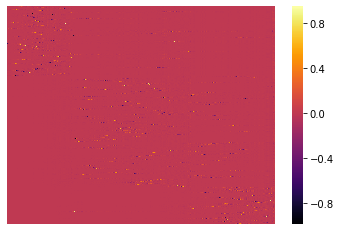

In [9]:
ortM = np.array(gram_schmidt_columns(np.real(eigenvec)))
sns.heatmap(pd.DataFrame(ortM), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno') 
#             robust=True)

## Here starts the VAE network

- Original input is the data len for JLA compilation-
- We try with 3 hidden layer
- We want that the latent space has 1 dimension to make a mapping with the redshift

In [40]:
original_dim = 740
intermediate_dim1 = 500
intermediate_dim2 = 300
intermediate_dim3 = 100
latent_dim = 5

inputs = tf.keras.Input(shape=(original_dim,))

h = layers.Dense(intermediate_dim1, activation='relu')(inputs)
h2 = layers.Dense(intermediate_dim2, activation='relu')(h)
h3 = layers.Dense(intermediate_dim3, activation='relu')(h2)
z_mean = layers.Dense(latent_dim)(h3)
z_log_sigma = layers.Dense(latent_dim)(h3)

### Define a sampling method

In [41]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.0, stddev=0.05)
    return z_mean + K.exp(z_log_sigma) * epsilon

Create a Lambda layer with z_mean, z_log_sigma and sampling method **

In [42]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [43]:
# Create encoder model
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim1, activation='relu')(latent_inputs)
x2 = layers.Dense(intermediate_dim2, activation='relu')(x)
x3 = layers.Dense(intermediate_dim3, activation='relu')(x2)

# Last layer returns original dimension
outputs = layers.Dense(original_dim, activation='relu')(x3)

# Decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

## Instantiate loss functions

- Reconstruction loss
- Kullback-Leiber divergence
- VAE loss

In [44]:
# reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [45]:
# Analize ortM
meanM = np.max(ortM)
stdM = np.std(ortM)
print(" max: {} \n min: {} \n mean: {} \n "
      "std: {} \n median: {} \n "
      .format(np.max(ortM), np.min(ortM), meanM, stdM, np.median(ortM)))

 max: 0.5000000000000001 
 min: -0.5 
 mean: 0.5000000000000001 
 std: 0.15406955768213243 
 median: -0.004176985328105856 
 


Separate the orthonormalized matrix into train and test set

In [46]:
split = 0.8
ntrain = int(split * len(eigenvec))
indx = [ntrain]
eigscaler = MinMaxScaler(feature_range=(-0.5, 0.5))
# eigscaler = MinMaxScaler(feature_range=(-1e-9, 1e-9))
# eigscaler = StandardScaler()
eigscaler.fit(ortM)
ortM = eigscaler.transform(ortM)
randomize = np.random.permutation(len(eigenvec))
ortM = ortM[randomize]
evec_train, evec_test = np.split(ortM, indx)
evec_train, evec_test = np.split(ortM, indx)

### TRAINING

In [47]:
vae_train = vae.fit(evec_train, evec_train,
        epochs=100,
        batch_size=4,
        shuffle=True,
        validation_data=(evec_test, evec_test))

Epoch 1/100
148/148 [==============================] - 1s 4ms/step - loss: 11.2977 - val_loss: 10.7708
Epoch 2/100
148/148 [==============================] - 1s 4ms/step - loss: 10.7641 - val_loss: 10.7721
Epoch 3/100
148/148 [==============================] - 1s 4ms/step - loss: 10.7643 - val_loss: 10.7755
Epoch 4/100
148/148 [==============================] - 1s 4ms/step - loss: 10.7022 - val_loss: 10.7048
Epoch 5/100
148/148 [==============================] - 1s 4ms/step - loss: 10.6840 - val_loss: 10.6949
Epoch 6/100
148/148 [==============================] - 1s 4ms/step - loss: 10.6833 - val_loss: 10.6966
Epoch 7/100
148/148 [==============================] - 1s 4ms/step - loss: 10.6828 - val_loss: 10.6975
Epoch 8/100
148/148 [==============================] - 1s 4ms/step - loss: 10.6836 - val_loss: 10.6966
Epoch 9/100
148/148 [==============================] - 1s 4ms/step - loss: 10.6818 - val_loss: 10.6883
Epoch 10/100
148/148 [==============================] - 1s 4ms/step - los

Epoch 80/100
148/148 [==============================] - 1s 4ms/step - loss: 10.5166 - val_loss: 10.5254
Epoch 81/100
148/148 [==============================] - 1s 4ms/step - loss: 10.5164 - val_loss: 10.5247
Epoch 82/100
148/148 [==============================] - 1s 5ms/step - loss: 10.5163 - val_loss: 10.5256
Epoch 83/100
148/148 [==============================] - 1s 5ms/step - loss: 10.5165 - val_loss: 10.5256
Epoch 84/100
148/148 [==============================] - 1s 4ms/step - loss: 10.5164 - val_loss: 10.5254
Epoch 85/100
148/148 [==============================] - 1s 4ms/step - loss: 10.5164 - val_loss: 10.5248
Epoch 86/100
148/148 [==============================] - 1s 4ms/step - loss: 10.5163 - val_loss: 10.5251
Epoch 87/100
148/148 [==============================] - 1s 4ms/step - loss: 10.5164 - val_loss: 10.5259
Epoch 88/100
148/148 [==============================] - 1s 4ms/step - loss: 10.5161 - val_loss: 10.5253
Epoch 89/100
148/148 [==============================] - 1s 4ms/s

### Evaluate performance

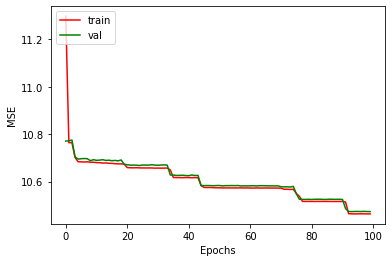

In [48]:
plt.plot(vae_train.history['loss'], color='r')
plt.plot(vae_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

Looking the latent space

(3, 148, 5) <class 'list'>


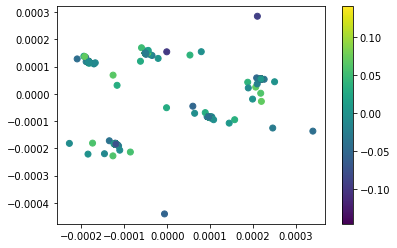

In [49]:
evec_test_encoded = encoder.predict(evec_test)
# plt.figure(figsize=(6, 6))
plt.scatter(evec_test_encoded[0], evec_test_encoded[1], c=evec_test_encoded[2])
plt.colorbar()
# plt.show()
print(np.shape(evec_test_encoded), type(evec_test_encoded))

Analize bounds of latent space:

In [50]:
# encoded_vals = encoder.predict(evec_test)
encoded_vals = encoder.predict(ortM)
maxlatent = np.max(encoded_vals)
minlatent = np.min(encoded_vals)

print(np.min(encoded_vals), np.max(encoded_vals), len(encoded_vals))
encoded_vals[2]

-0.15234524 0.18014118 3


array([[-0.08669343, -0.01659375, -0.03756006,  0.01935272,  0.06320124],
       [-0.02611273, -0.01219057, -0.00709377,  0.01251221, -0.03236155],
       [ 0.03877371, -0.00179626,  0.04650323, -0.0455363 , -0.08951925],
       ...,
       [ 0.02479869,  0.06493451,  0.03511325, -0.02184067,  0.0878577 ],
       [-0.0196329 ,  0.0371517 , -0.00032235, -0.01146798, -0.06124885],
       [ 0.02337924, -0.02511616,  0.00153408,  0.09319316, -0.10631844]],
      dtype=float32)

## Generate synthetic covariance matrix

740


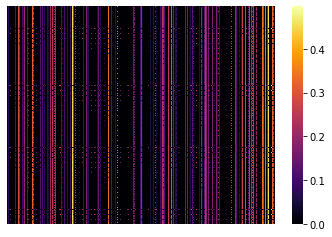

In [53]:
# r = np.random.uniform(minlatent, maxlatent, size=740)
r = np.random.rand(740,5)
print(len(r))
# r = np.linspace(minlatent, maxlatent, 740)
# rs = eigscaler.transform(r)
pred_random = decoder.predict(r)
pred_random = eigscaler.inverse_transform(pred_random)
df_pred = pd.DataFrame(pred_random)
sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno') 
#             robust=True')

In [ ]:
pred_random

In [ ]:
ortM 